# Impact of Stock Portfolio Diversification on Portfolio Risks

# Abstract

This project aims to explore the intricate relationship between stock portfolio diversification and the consequent reduction in portfolio risks. With a focus on how the number of stocks and sectors within a portfolio correlates with risk mitigation, the study delves into understanding the dynamics of diversification in investment portfolios. The central research questions probe the impact of diversification levels on overall risk reduction, the correlation between the number of stocks/sectors and the decrease in risks, and the quest for an optimal diversification level.


# Introduction

The aim of this project is to analyse how the level of diversification in a stock portfolio influences the overall reduction in portfolio risks. We will explore the correlation between the number of stocks or sectors in a portfolio and the corresponding decrease in portfolio risks. Additionally, we will investigate whether there exists an optimal diversification level beyond which further additions do not significantly reduce risks.

Team Members

1. Dharani Goalla
2. Sahil Kakkar
3. Venkata Narasa Reddy Boreddy

### Research Questions:

1. How does the level of stock portfolio diversification impact the reduction of overall portfolio risks?
<br>
2.	Explore the correlation between the number of stocks or sectors in a portfolio and the corresponding decrease in portfolio risks.
<br>
3.	Investigate if there exists an optimal diversification level beyond which further additions do not significantly reduce risks.
<br>

## Research Approach

Utilizing data sources such as the Alpha Vantage API for stock prices and volume, and Yahoo Finance for sector information, the project employs web scraping and API methods for data sourcing. The subsequent data integration and transformation process is meticulously planned. Analytical methods encompass correlation coefficient calculations and interpolation models to ascertain the point of diminishing returns in risk reduction. The project's ultimate goal is to identify whether an optimal level of diversification exists, beyond which additional diversification does not significantly contribute to risk mitigation.


# 1. Data Integration and Transformation Pipeline:

In [1]:
import requests
import pandas as pd
import csv
import psycopg2
from psycopg2 import sql
import time
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

In [2]:
# Alpha Vantage API key1d
api_key = "9FBRN4C607Z33XM0"
APLHA_VANTAGE_BASE_URL = 'https://www.alphavantage.co/query'

#Database Connection in Python

The get_db_connection function creates a connection to a PostgreSQL database using psycopg2.

Parameters: No external parameters required.
Returns: A connection object to the  database

NOTE: Adjust the host, database, user, and password as per your configuration.

In [4]:
# Function to get a database connection
def get_db_connection():
    '''creates and returns a connection object to the PostgreSQL database.'''
    return psycopg2.connect(
        host="localhost",
        database="STOCKS", # Database name
        user="postgres", # your username
        password="123456789" #your
    )
  


# 1.1 NYSE Symbols Fetcher

The fetch_symbols function retrieves a list of active listing symbols from the NYSE exchange using the Alpha Vantage API.

# Workflow:

1. Calls the Alpha Vantage API with LISTING_STATUS function.
Parses the CSV response to a pandas DataFrame.

2. Filters the DataFrame to include only NYSE stocks.

# Returns:
 A DataFrame with columns: 'symbol', 'name', 'exchange', 'assetType'.

# Requirements:

Requests and csv libraries for API call and CSV parsing.
pandas for DataFrame operations.

In [5]:
# Function to fetch symbols from Alpha Vantage
def fetch_symbols():
    '''Fetches active listing symbols from NYSE exchange'''
    function = 'LISTING_STATUS'
    symbols_url = f'{APLHA_VANTAGE_BASE_URL}?function={function}&apikey={api_key}'
    response = requests.get(symbols_url)
    decoded_content = response.content.decode('utf-8')
    csv_reader = csv.reader(decoded_content.splitlines(), delimiter=',')
    symbols_list = list(csv_reader)
    columns = symbols_list[0]
    symbols_df = pd.DataFrame(symbols_list[1:], columns=columns)

    # Filter for NYSE and Stocks
    nyse_stocks = symbols_df[(symbols_df['exchange'] == 'NYSE') & (symbols_df['assetType'] == 'Stock')]

    return nyse_stocks[['symbol', 'name', 'exchange', 'assetType']]


# 1.2 Data Insertion into PostgreSQL Database

The insert_data_into_database function inserts data into a PostgreSQL database from two DataFrames: df_symbols and df_stock_data.

# Process:

**Symbols Table Insertion**: Iterates over df_symbols, inserting each symbol into the symbols table. Utilizes ON CONFLICT to avoid duplicates and populates symbol_id_dict with returned IDs.

**Stock Data Insertion**: Iterates over df_stock_data, using symbol_id_dict to fetch the corresponding ID and inserts each row into the stock_data table.

# Parameters:

conn: Database connection object.
df_symbols: DataFrame with symbol information.
df_stock_data: DataFrame with stock market data.

# Error Handling:

Catches exceptions during insertion, printing the error message.
Ensures the cursor is closed in the finally block.

# Transaction Management:

Commits data after inserting symbols and stock data to ensure database integrity.


In [6]:
# Function to insert data into the PostgreSQL database
def insert_data_into_database(conn, df_symbols, df_stock_data):
    '''Inserts symbols and stock time series data in to respective tables stock_data and symbols'''
    try:
        # Create a cursor
        cursor = conn.cursor()

        # Insert data into symbols table and create symbol_id dictionary
        symbol_id_dict = {}
        for index, row in df_symbols.iterrows():

            insert_query = sql.SQL("""
                INSERT INTO symbols (symbol, name, exchange, asset_type)
                VALUES (%s, %s, %s, %s)
                ON CONFLICT (symbol) DO NOTHING
                RETURNING id
            """)
            cursor.execute(insert_query, (row['symbol'], row['name'], row['exchange'], row['assetType']))
            result = cursor.fetchone()
            if result:
                symbol_id_dict[row['symbol']] = result[0]

        # Commit the symbols data
        conn.commit()

        # Insert data into stock_data table using symbol_id dictionary
        for index, row in df_stock_data.iterrows():
            symbol_id = symbol_id_dict.get(row['symbol'])
            if symbol_id is not None:
                # Insert into stock_data table
                insert_query = sql.SQL("""
                    INSERT INTO stock_data (symbol_id, date, open, high, low, close, volume)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                """)
                cursor.execute(insert_query, (symbol_id, row['date'], row['open'], row['high'], row['low'], row['close'], row['volume']))

        # Commit the stock data
        conn.commit()

    except Exception as e:
        print(f"Error inserting data into database: {e}")

    finally:
        # Close the cursor
        cursor.close()

# 1.3 Fetching Stock Data from Alpha Vantage

The fetch_stock_data function retrieves daily time series data for a specified stock symbol from the Alpha Vantage API.

# Process:

**API Request**: Sends a request to the Alpha Vantage API with the symbol, function (TIME_SERIES_DAILY), and output format (JSON).

**Data Processing**: If the request is successful, the function converts the JSON response to a Pandas DataFrame, with columns cleaned to remove non-alphabetic characters and dates parsed accordingly. A 'symbol' column is also added to the DataFrame.

**Error Handling**: Catches and prints any exceptions or non-200 status codes, returning None in these cases.

# Parameters:

**symbol**: The stock symbol for which the data is being fetched.

# Returns:

A Pandas DataFrame with columns corresponding to date, open, high, low, close, and volume of the stock for each day.

In [10]:
# Function to fetch stock data for a symbol from Alpha Vantage
def fetch_stock_data(symbol):
    '''retrieves daily time series data for a specified stock symbol from the Alpha Vantage API.'''
    try:
        function = "TIME_SERIES_DAILY"
        output_format = "json"

        url = f"{APLHA_VANTAGE_BASE_URL}?function={function}&symbol={symbol}&outputsize=full&apikey={api_key}&datatype={output_format}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if output_format == "json":
                df = pd.DataFrame.from_dict(data["Time Series (Daily)"]).T
                df.index = pd.to_datetime(df.index)
                df.columns = ["".join(filter(str.isalpha, col)) for col in df.columns]
                df = df.rename_axis("date").reset_index()
                df['symbol'] = symbol  # Add symbol column
                return df
        else:
            print(f"Error fetching data for {symbol}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching data for symbol:{symbol} {e}")
        return None


    

# 1.4 Populating Stock Data

The populate_stocks function automates the process of populating stock data into a PostgreSQL database by fetching symbols and their respective stock data.

# Process:

**Fetch Symbols**: Retrieves symbols using fetch_symbols and resets its index for easy iteration.

**Database Connection:** Establishes a connection to the database and fetches existing symbols to avoid duplication.

**Data Filtering:** Eliminates symbols already present in the database from the newly fetched symbols list.

**Batch Processing:**
1. The symbols are processed in batches (default size: 29) to manage API requests and database operations efficiently.

2. For each batch, stock data is fetched concurrently using ThreadPoolExecutor.
3. Filters out any None values resulting from failed API requests.
4. Merges individual DataFrames into a single DataFrame.
5. Inserts the fetched data into the database using insert_data_into_database.
**API Rate Limiting:** Includes a 60-second delay between batches to comply with API rate limits.
**Database Connection Closure:** Closes the database connection after completing the data insertion.

In [11]:

def populate_stocks():
    '''Populates symbols and stocks time series with batch processing mechanism'''
    # Fetch symbols
    symbols_df = fetch_symbols().reset_index()
    # print(symbols_df)
    # Establish a database connection
    conn = get_db_connection()
    cursor = conn.cursor()
    query = "SELECT * FROM symbols;"
    select_query = sql.SQL(query)
    cursor.execute(select_query)
    data = cursor.fetchall()
    symbols_db = [symbol[1] for symbol in data]
    # Filter out symbols present in the database from symbols_df
    symbols_df = symbols_df[~symbols_df['symbol'].isin(symbols_db)]


# Use the connection to execute the query and fetch data into a DataFrame
    print(symbols_df)
    # Fetch stock data for each symbol in batches
    batch_size = 29
    for i in range(0, len(symbols_df), batch_size):
        symbols_batch = symbols_df.iloc[i:i + batch_size]
        # Fetch stock data for each symbol in the batch using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=batch_size) as executor:
            stock_data_batch = list(executor.map(fetch_stock_data, symbols_batch['symbol']))
            # Filter out None values (failed requests)
            stock_data_batch = [data for data in stock_data_batch if data is not None]

            # Convert the list of DataFrames to a single DataFrame
            stock_data_df = pd.concat(stock_data_batch, ignore_index=True)

            # Insert data into the PostgreSQL database
            insert_data_into_database(conn, symbols_batch, stock_data_df)

            # Introduce a delay to stay within API rate limits
            time.sleep(60)  # Delay for 1 minute before the next batch

    # Close the database connection
    conn.close()

populate_stocks()

      index symbol                                         name exchange  \
1005   3958   FLYX                EG Acquisition Corp - Class A     NYSE   
1006   3959  FLYXW  EG Acquisition Corp - Warrants (28/05/2028)     NYSE   

     assetType  
1005     Stock  
1006     Stock  


# 1.5 Function: Get Sector from Alpha Vantage API

The get_sector_from_api function is designed to retrieve the sector information for a specific stock symbol using the Alpha Vantage API.

# Functionality:

# Purpose: Fetches the sector of a given stock symbol.

# Parameters:
**symbol**: The stock symbol for which the sector information is required.

# Process:

1. Constructs the API request URL incorporating the function (OVERVIEW), stock symbol, and API key.
2. Sends a GET request to the Alpha Vantage API.
3. Parses the JSON response to extract the sector information.

# Return Value:
Returns the sector of the given stock symbol. If the sector information is not available, returns None.

In [12]:
# Function to get the sector from the Alpha Vantage API
def get_sector_from_api(symbol):
    '''Fetches sector data using Aplha vontage api using OVERVIEW Function'''
    url = f"{APLHA_VANTAGE_BASE_URL}?function=OVERVIEW&symbol={symbol}&apikey={api_key}"
    r = requests.get(url)
    data = r.json()
    return data.get('Sector', None)

# 1.6 Function: Get Symbol Sector from Yahoo Finance

# Overview
The function get_symbol_sector scrapes sector information for a given stock symbol from Yahoo Finance using BeautifulSoup.

# Functionality
Purpose: Extracts sector data of a specific stock symbol.

# Parameters:
symbol: The stock symbol for which sector data is required.

# Process:
1. Constructs the URL for the Yahoo Finance profile page of the stock.
2. Performs an HTTP GET request to fetch the page content.
3. Parses the HTML content using BeautifulSoup to find the sector data.

# Return Value: The sector name if found; otherwise, returns None.

# Limitations
1. This method is not fully reliable: only about 30% of the symbols' sectors could be retrieved.
2. The limitation arises due to BeautifulSoup's inability to interact with dynamic content on web pages.

# Function: Populate Sectors
The populate_sectors function updates the 'symbols' table in a PostgreSQL database with sector information for symbols where this data is currently missing.

# Process:
1. Connects to the database.
2. Retrieves symbols with missing sector information.
3. For each symbol, fetches the sector using get_symbol_sector.
4. Updates the database with the fetched sector information.
5. Commits changes and closes the connection.

# Note
The scraping approach is subject to the layout and accessibility of Yahoo Finance's webpage and may require updates if the site structure changes.
To enhance reliability, consider using a more interactive scraping tool or an official finance API.

In [13]:
# Function to get the sector from Yahoo Finance using BeautifulSoup
def get_symbol_sector(symbol):
    url = f"https://finance.yahoo.com/quote/{symbol}/profile"
    response = requests.get(url)
    print(response)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        target_element = soup.find('div', class_='asset-profile-container')
        sector_element = target_element.find('span', string='Sector(s)')
        if sector_element:
            sector_data = sector_element.find_next('span', class_='Fw(600)').string
            return sector_data.strip()
    return None

def populate_sectors():
    conn = get_db_connection()
    cursor = conn.cursor()
    query = "SELECT * FROM symbols WHERE sector IS NULL"
    select_query = sql.SQL(query)
    cursor.execute(select_query)
    data = cursor.fetchall()
    symbols_db = [symbol[1] for symbol in data]
    print(len(symbols_db))
    for symbol in symbols_db:
        sector = get_symbol_sector(symbol)
        update_query = sql.SQL("UPDATE symbols SET sector = %s WHERE symbol = %s")
        cursor.execute(update_query, (sector, symbol))
        conn.commit()
        time.sleep(1)
    conn.close()

populate_sectors()

86
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [404]>
<Response [

# 1.7 Function: Get Symbol Sector Using Selenium

# Overview
This function get_symbol_sector_selenium extracts sector information for a given stock symbol from Yahoo Finance using Selenium WebDriver.

# Functionality
**Purpose:** To retrieve sector data for a specific stock symbol with enhanced accuracy.
**Parameters:**
**symbol**: The stock symbol for which sector data is required.
**driver:** An instance of Selenium WebDriver.

# Process:
1. Generates the correct URL for the Yahoo Finance profile of the stock.
2. Navigates to the URL using the Selenium WebDriver.
3. Waits for the necessary element (sector information) to load.
4. Extracts and returns the sector information.

# Return Value: The sector name if found; otherwise, returns None.

# Function: Populate Sectors with Selenium
The function populate_sectors_selenium updates the 'symbols' table in a PostgreSQL database with sector information, using Selenium for web scraping.

#Process:
1. Sets up a headless Chrome WebDriver.
2. Connects to the database and fetches symbols with missing sector information.
3. For each symbol, uses Selenium to fetch the sector.
4. Updates the database with the fetched sector information.
5. Commits changes and closes both the database connection and WebDriver.

# Note
Selenium allows dynamic interaction with web pages, offering improved accuracy over static scraping methods like BeautifulSoup.
This method is more robust against changes in web page structure but also more resource-intensive. We have achieved upto 85% of sector data with this approach and 15% had failed due to missing sector info in yahoo finance
# Limitations
Performance: Selenium is generally slower compared to direct HTTP requests.
Complexity: Requires handling WebDriver setup and maintenance.


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

def get_symbol_sector_selenium(symbol, driver):
    '''Getting the sector data using selenium'''
    first_hyphen_index = symbol.find('-')
    modified_string = symbol[:first_hyphen_index + 1] + symbol[first_hyphen_index + 1:].replace('-', '')
    url = f"https://finance.yahoo.com/quote/{modified_string}/profile"
    driver.get(url)
    try:
        # Wait for the target element to be present
        target_element = WebDriverWait(driver, 5).until(
          EC.presence_of_element_located((By.CLASS_NAME, "asset-profile-container"))
        )
        sector_element = target_element.find_element(By.XPATH, "//span[text()='Sector(s)']/following-sibling::span[@class='Fw(600)']")
        return sector_element.text.strip()
    except Exception as e:
        print(f"Error getting sector for {symbol}: {e}")
        return None

def populate_sectors_selenium():
    '''Populating the sector data using selenium'''
    chrome_options = Options()
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--headless')  # We can remove this line if you want to see the browser
    driver = webdriver.Chrome(options=chrome_options)
    try:
        conn = get_db_connection()
        cursor = conn.cursor()
        query = "SELECT * FROM symbols WHERE sector IS NULL order by symbol ASC"
        select_query = sql.SQL(query)
        cursor.execute(select_query)
        data = cursor.fetchall()
        symbols_db = [symbol[1] for symbol in data]

        for symbol in symbols_db:
            sector = get_symbol_sector_selenium(symbol, driver)
            print(symbol,sector)
            if sector is not None:
                update_query = sql.SQL("UPDATE symbols SET sector = %s WHERE symbol = %s")
                cursor.execute(update_query, (sector, symbol))
                conn.commit()

        print("Sectors populated successfully!")
    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Close database connection and WebDriver
        conn.close()
        driver.quit()

populate_sectors_selenium()


# 1.8 Function: Populate Missing Sectors

# Overview
The function populate_missing_sectors aims to update the sectors for stock symbols in a database where this information is currently missing.

# Functionality
**Purpose:** To populate the 'sector' field for stock symbols in the 'symbols' table of a PostgreSQL database using web scrapping.

**Database Interaction:** Queries the database for stock symbols without sector information and updates them.
**Concurrency:** Utilizes multi-threading for efficient data processing.
**Batch Processing:** Handles symbols in batches to optimize performance and manage API rate limits.

#Process

 **Database Connection:** Establishes a connection to the PostgreSQL database.
 **Data Retrieval:** Fetches symbols with missing sector information.
 ** Batch Processing:**
1. Processes symbols in batches of 30.
2. For each batch, retrieves sector information in parallel using ThreadPoolExecutor.
3. Updates the database with the retrieved sector information.
**API Throttling:** Introduces a delay between batches to comply with API rate limits.
**Database Update:** Commits the updates to the database.
**Clean-up:** Closes the database connection upon completion.

In [15]:
def populate_missing_sectors():
    '''populating missing sector using alpha vantage API'''
    conn = get_db_connection()
    cursor = conn.cursor()
    query = "SELECT * FROM symbols WHERE sector IS NULL"
    select_query = sql.SQL(query)
    cursor.execute(select_query)
    data = cursor.fetchall()
    symbols_db = [symbol[1] for symbol in data]
    print(symbols_db)
    batch_size = 30
    for i in range(0, len(symbols_db), batch_size):
        symbols_batch = symbols_db[i:i + batch_size]
        # Use concurrent.futures.ThreadPoolExecutor for parallel execution
        with ThreadPoolExecutor() as executor:
            # Map the get_sector function to each symbol in parallel
            sectors = list(executor.map(get_sector_from_api, symbols_batch))
            for symbol, sector in zip(symbols_batch, sectors):
                update_query = sql.SQL("UPDATE symbols SET sector = %s WHERE symbol = %s")
                cursor.execute(update_query, (sector, symbol))
            conn.commit()
            time.sleep(40)
        # Update the sectors in the database
    conn.close()
populate_missing_sectors()

['FG-W', 'BC/PC', 'BWA-W', 'HZON-WS', 'K-W', 'KIO-R', 'KLG-W', 'KNF-W', 'KVUE-W', 'LAAC-W', 'LAC-W', 'LH-W', 'NTEST-A', 'NTEST-B', 'NTEST-C', 'NTEST-G', 'NTEST-J', 'NTEST-L', 'NTEST-M', 'NTEST-N', 'NTEST-O', 'NTEST-P', 'NTEST-Q', 'NTEST-Z', 'IGR-R-W', 'ISG', 'PDX', 'WS', 'ZEV-WS', 'MDU-W', 'STZ-B', 'BC/PA', 'BOAC-U', 'BOAC-WS', 'DSX-WS', 'CR-W', 'TMAC', 'TMAC-U', 'VLTO-W', 'WS-W', 'VSTS-W', 'VTS-W', 'VYX-W', 'EOCW', 'EXTO-W', 'FLAG-WS', 'ARMK-W', 'BC/PB', 'CCV-WS', 'HTPA-U', 'ICNC-U', 'KIO-R-W', 'LGV-WS', 'NEE-P-Q', 'FGN', 'NTEST-K', 'OWL-WS', 'IGR-R', 'PHIN-W', 'JNJ-WD', 'MBC-W', 'NATL-W', 'ALLG-WS', 'NRUC', 'RBT-WS', 'SPHR-W', 'RSF-R', 'RSF-R-W', 'USX', 'BN-W', 'BBLN', 'BOAC', 'CBX', 'CCV', 'TGR-WS', 'WOR-W', 'WPC-W', 'AXAC-R', 'CCV-U', 'CRHC-U', 'CXT-W', 'EFC-P-D', 'EFC-P-E', 'ZKH', 'FLYX', 'FLYXW']


# 2. Data Preparation and Portfolio Construction 

## 2.1 Loading Data base into python enivornment

In [16]:
conn = get_db_connection()
query = "SELECT * FROM symbols;"

# Load data into DataFrame
symbols_df = pd.read_sql(query, conn)
print(symbols_df)
conn.close()

       id   symbol                                               name  \
0     894     ECCX                     Eagle Point Credit Company Inc   
1     911   EGGF-U  EG Acquisition Corp - Units (1 Ord Share Class...   
2     912  EGGF-WS        EG Acquisition Corp - Warrants (28/05/2028)   
3     925     ELAN                           Elanco Animal Health Inc   
4     926      ELC                              Entergy Louisiana LLC   
...   ...      ...                                                ...   
2749  776    CXT-W            Crane NXT Co. ExDistribution WhenIssued   
2750    2  EFC-P-D                            Ellington Financial Inc   
2751    3  EFC-P-E                            Ellington Financial Inc   
2752    5     FLYX                      EG Acquisition Corp - Class A   
2753    6    FLYXW        EG Acquisition Corp - Warrants (28/05/2028)   

     exchange asset_type                      sector  
0        NYSE      Stock                  TECHNOLOGY  
1        NYSE

C:\Users\Venkata Narasa Reddy\AppData\Local\Temp\ipykernel_23148\542174356.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  symbols_df = pd.read_sql(query, conn)


We start by establishing a connection to a database using a custom function, get_db_connection(). Once connected, we execute an SQL query to select all records from the 'symbols' table. This data is then loaded into a Pandas DataFrame, symbols_df, which allows us to easily handle and analyze the data in Python. After printing the DataFrame to review its contents, we close the database connection to maintain good database management practices and avoid leaving open, unused connections. Similarly done for stock_df below.

In [17]:
conn = get_db_connection()
query = "SELECT * FROM stock_data;"

# Load data into DataFrame
stocks_df = pd.read_sql(query, conn)
print(stocks_df)
conn.close()

C:\Users\Venkata Narasa Reddy\AppData\Local\Temp\ipykernel_23148\3999285982.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stocks_df = pd.read_sql(query, conn)


              id  symbol_id        date   open     high    low    close  \
0              1          1  2023-12-15   0.26   0.4400   0.22   0.3600   
1              2          1  2023-12-14   0.35   0.5852   0.31   0.3319   
2              3          2  2023-12-15  20.30  20.3000  20.30  20.3000   
3              4          2  2023-12-14  20.30  20.3000  20.30  20.3000   
4              5          3  2023-12-15  24.00  24.9950  24.00  24.7200   
...          ...        ...         ...    ...      ...    ...      ...   
8535558  7019126       2957  2023-05-23   8.16   8.9700   8.02   8.7100   
8535559  7019127       2957  2023-05-22   8.01   8.2900   7.82   8.1100   
8535560  7019128       2957  2023-05-19   7.85   7.9700   7.67   7.6900   
8535561  7019129       2957  2023-05-18   8.15   8.1900   7.76   7.7900   
8535562  7019130       2957  2023-05-17   7.95   8.1817   7.80   8.1500   

            volume  
0         467945.0  
1          18710.0  
2            100.0  
3              

## 2.2 Merging the Databases

As we need single unified database for our analysis we are merging the both "symbols_df" and "stock_df" databases into a single data base.We merge two DataFrames, stocks_df and symbols_df, on the columns symbol_id and id respectively, creating a new DataFrame merged_df.

In [63]:
# Merging the DataFrames on the 'symbol_id' from Stocks.csv and 'id' from symbols.csv
merged_df = pd.merge(stocks_df, symbols_df, left_on='symbol_id', right_on='id')

# merged DataFrame with columns from both Stocks.csv and symbols.csv
# Printing the first few rows of the merged DataFrame
merged_df.head()

,id_x,symbol_id,date,open,high,low,close,volume,id_y,symbol,name,exchange,asset_type,sector
0,1,1,2023-12-15,0.26,0.4400,0.22,0.3600,467945.0,1,DSX-WS,Diana Shipping Inc - Warrants (14/12/2026),NYSE,Stock,None
1,2,1,2023-12-14,0.35,0.5852,0.31,0.3319,18710.0,1,DSX-WS,Diana Shipping Inc - Warrants (14/12/2026),NYSE,Stock,None
2,3,2,2023-12-15,20.30,20.3000,20.30,20.3000,100.0,2,EFC-P-D,Ellington Financial Inc,NYSE,Stock,None
3,4,2,2023-12-14,20.30,20.3000,20.30,20.3000,0.0,2,EFC-P-D,Ellington Financial Inc,NYSE,Stock,None
4,5,3,2023-12-15,24.00,24.9950,24.00,24.7200,2999.0,3,EFC-P-E,Ellington Financial Inc,NYSE,Stock,None


## 2.3 Data Cleaning

In our data analysis process, we aim to streamline and optimize our dataset for efficient time series analysis. To achieve this, we first remove the duplicate 'id' columns, labeled as 'id_x' and 'id_y', as they are redundant and could complicate our analysis. Next, we rename the 'symbol_id' column to 'id' for simplicity and consistency, making it easier to reference. Understanding the importance of time in our analysis, we convert the 'date' column to a datetime format, ensuring accurate temporal data handling. Finally, we set the 'date' column as the index, which is a crucial step for time series analysis, as it allows us to efficiently perform operations and analyses that are time-dependent, improving both the clarity and functionality of our dataset.

In [64]:
# Removing the duplicate id columns
merged_df.drop(columns=['id_x', 'id_y'], inplace=True)

# Renaming the 'symbol_id' column to just 'id' 
merged_df.rename(columns={'symbol_id': 'id'}, inplace=True)

# Convert the 'date' column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index as we plan to perform time series analysis
merged_df.set_index('date', inplace=True)

# Now the DataFrame is cleaned up and ready for analysis
merged_df.head()

,id,open,high,low,close,volume,symbol,name,exchange,asset_type,sector
date,,,,,,,,,,,
2023-12-15,1,0.26,0.4400,0.22,0.3600,467945.0,DSX-WS,Diana Shipping Inc - Warrants (14/12/2026),NYSE,Stock,None
2023-12-14,1,0.35,0.5852,0.31,0.3319,18710.0,DSX-WS,Diana Shipping Inc - Warrants (14/12/2026),NYSE,Stock,None
2023-12-15,2,20.30,20.3000,20.30,20.3000,100.0,EFC-P-D,Ellington Financial Inc,NYSE,Stock,None
2023-12-14,2,20.30,20.3000,20.30,20.3000,0.0,EFC-P-D,Ellington Financial Inc,NYSE,Stock,None
2023-12-15,3,24.00,24.9950,24.00,24.7200,2999.0,EFC-P-E,Ellington Financial Inc,NYSE,Stock,None


In [65]:
# Checking the info for the merged data frame
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8535563 entries, 2023-12-15 to 1999-11-01
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   open        float64
 2   high        float64
 3   low         float64
 4   close       float64
 5   volume      float64
 6   symbol      object 
 7   name        object 
 8   exchange    object 
 9   asset_type  object 
 10  sector      object 
dtypes: float64(5), int64(1), object(5)
memory usage: 781.5+ MB
None


In [66]:
# describing the basic stats of the dataframe
merged_df.describe()

,id,open,high,low,close,volume
count,8.535563e+06,8.535563e+06,8.535563e+06,8.535563e+06,8.535563e+06,8.535563e+06
mean,1.681048e+03,2.087492e+02,2.102253e+02,2.070907e+02,2.086708e+02,1.730159e+06
std,1.108516e+03,6.725096e+03,6.762916e+03,6.679644e+03,6.720913e+03,8.263727e+06
min,1.000000e+00,1.000000e-04,2.000000e-04,1.000000e-04,2.000000e-04,0.000000e+00
25%,7.630000e+02,1.587000e+01,1.611000e+01,1.560000e+01,1.586000e+01,8.518900e+04
50%,1.431000e+03,2.752000e+01,2.785900e+01,2.719000e+01,2.752000e+01,3.889000e+05
75%,2.609000e+03,5.085000e+01,5.145000e+01,5.023000e+01,5.085000e+01,1.344732e+06
max,3.937000e+03,5.635490e+05,5.665700e+05,5.591000e+05,5.630728e+05,3.772638e+09


In [67]:
# Check for missing values
print(merged_df.isnull().sum())

id                0
open              0
high              0
low               0
close             0
volume            0
symbol            0
name              0
exchange          0
asset_type        0
sector        38457
dtype: int64



In our data cleaning process, we chose to drop rows where the 'name' or 'sector' information was missing. This decision was based on two key considerations. Firstly, these missing values represent less than 1% of our entire dataset, making their removal a minimal sacrifice for the sake of data quality. Secondly, we have already performed extensive imputation for missing symbols, addressing other significant data gaps. Thus, dropping rows with missing 'name' or 'sector' information is a strategic move to maintain the integrity of our dataset without significantly impacting its size or representativeness. This ensures that our analysis is both accurate and robust, focusing on the most complete and reliable data available.

In [68]:
# Drop rows where 'name' or 'sector' is missing
merged_df.dropna(subset=['name', 'sector'], inplace=True)
print(merged_df.isnull().sum())

id            0
open          0
high          0
low           0
close         0
volume        0
symbol        0
name          0
exchange      0
asset_type    0
sector        0
dtype: int64


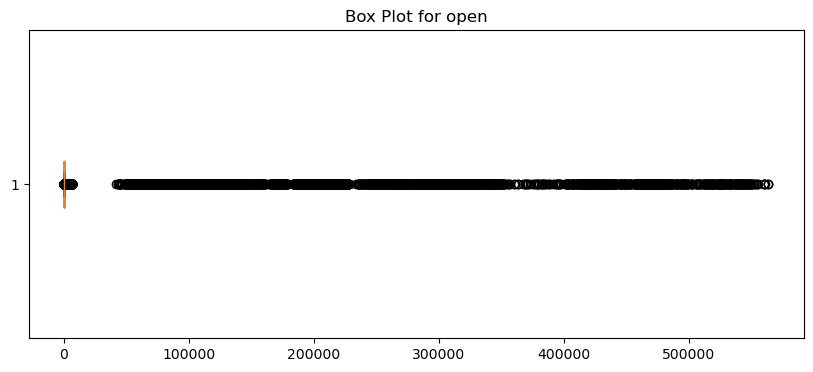

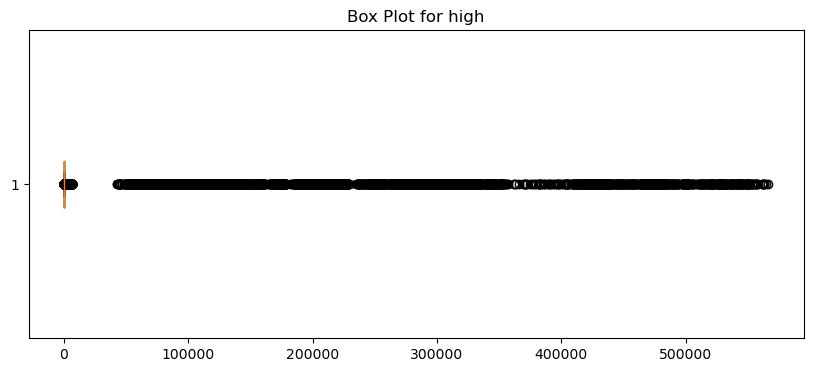

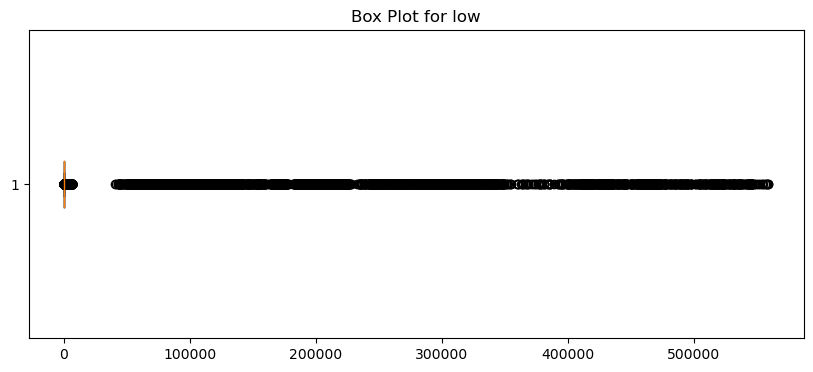

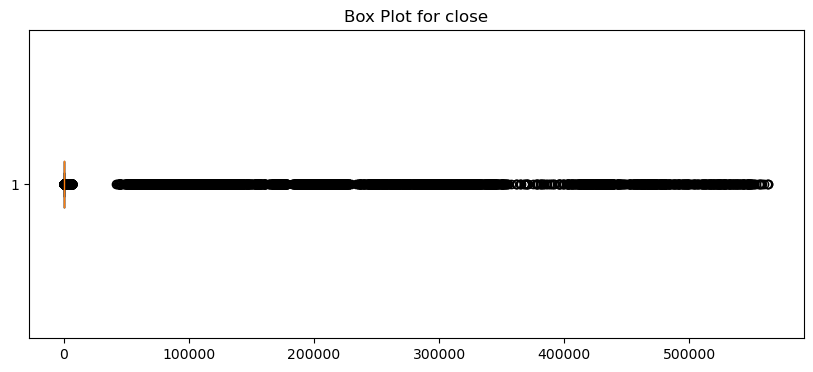

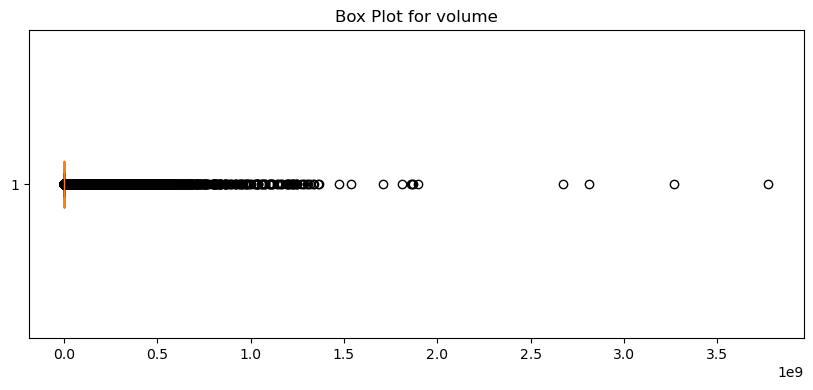

In [69]:
# Checking for outliers
import matplotlib.pyplot as plt

# List of columns to check for outliers
columns_to_check = ['open', 'high', 'low', 'close', 'volume']

# Creating box plots
for column in columns_to_check:
    plt.figure(figsize=(10, 4))
    plt.boxplot(merged_df[column].dropna(), vert=False)
    plt.title(f'Box Plot for {column}')
    plt.show()


<strong> Observation </strong> In our data analysis, while examining for outliers, we used box plots to assess key financial metrics such as 'open', 'high', 'low', 'close', and 'volume'. Indeed, we observed outliers in these distributions. However, we decided against normalizing or removing these outliers, particularly in the 'volume' data. This decision is critical for our risk analysis, as these outliers can represent significant market events or trends that are essential for understanding market volatility and risk. By retaining these outliers, we ensure that our analysis captures the full spectrum of market behaviors, including extreme but informative fluctuations. This approach allows us to maintain a comprehensive and realistic view of the market dynamics, which is crucial for accurate risk assessment.

## 2.4 Data Formatting

In [70]:
# Standardising data formats
# 1. Converting Categorical Columns to Category Data Type

categorical_columns = ['symbol', 'exchange', 'asset_type', 'sector']
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype('category')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8497106 entries, 2023-05-16 to 1999-11-01
Data columns (total 11 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          int64   
 1   open        float64 
 2   high        float64 
 3   low         float64 
 4   close       float64 
 5   volume      float64 
 6   symbol      category
 7   name        object  
 8   exchange    category
 9   asset_type  category
 10  sector      category
dtypes: category(4), float64(5), int64(1), object(1)
memory usage: 559.2+ MB
None


In [71]:
# 2. Ensuring Numerical Columns are in Correct Format using to numeric (just for thorough formatting)

numerical_columns = ['open', 'high', 'low', 'close', 'volume']
merged_df[numerical_columns] = merged_df[numerical_columns].apply(pd.to_numeric, errors='coerce')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8497106 entries, 2023-05-16 to 1999-11-01
Data columns (total 11 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          int64   
 1   open        float64 
 2   high        float64 
 3   low         float64 
 4   close       float64 
 5   volume      float64 
 6   symbol      category
 7   name        object  
 8   exchange    category
 9   asset_type  category
 10  sector      category
dtypes: category(4), float64(5), int64(1), object(1)
memory usage: 559.2+ MB
None


In our data processing, we focused on ensuring that all numerical columns are correctly formatted. To achieve this, we specifically targeted columns like 'open', 'high', 'low', 'close', and 'volume'. We used the pd.to_numeric method from pandas to convert these columns into a numerical format. The errors='coerce' parameter is particularly important as it transforms any non-numeric values into NaNs, thereby avoiding data type conflicts. This step is crucial for maintaining the integrity and consistency of our dataset, as it ensures that all numerical data is in a format suitable for accurate and efficient statistical analysis. 

In [72]:
# changing date index to datetime format for easier manipulation

merged_df.index = pd.to_datetime(merged_df.index)

## 2.5 Adding additional required columns for Analysis

In [73]:
import numpy as np
# 1. Log Transformation 

# Log transformation of price and volume columns
for column in ['open', 'high', 'low', 'close', 'volume']:
    merged_df[f'log_{column}'] = np.log(merged_df[column] + 1) 



In our financial data analysis, we applied a log transformation to the price and volume columns ('open', 'high', 'low', 'close', 'volume'). We did this to stabilize the variance across these data points and to make their distribution more akin to a normal distribution. This transformation is particularly beneficial for certain types of statistical analyses where normality of data is a key assumption. By using the natural logarithm and adding one to each value (to avoid issues with zero values), we can better interpret and analyze trends and patterns in the data, especially when dealing with wide-ranging values. This step is crucial for enhancing the accuracy and effectiveness of our subsequent statistical and predictive modeling efforts.

In [74]:
# 2. Calculating Returns 
merged_df['daily_return'] = merged_df['close'].pct_change()


 we calculated daily returns instead of using absolute price values. This approach is more meaningful for risk and performance analysis. By computing the percentage change in the 'close' price from one day to the next using the pct_change() method, we capture the rate of return or loss for each day. This metric is crucial because it standardizes price movements across different stocks, allowing us to compare performance irrespective of the stock's absolute price. Returns provide a clearer picture of relative performance and risk, which is essential in financial analysis for making informed investment decisions and understanding market dynamics.

In [75]:
# 3. Moving Averages 
# 7-day and 30-day moving averages
merged_df['ma_7'] = merged_df['close'].rolling(window=7).mean()
merged_df['ma_30'] = merged_df['close'].rolling(window=30).mean()

 we calculated moving averages to identify trends over time. Specifically, we computed 7-day and 30-day moving averages of the 'close' prices, using the rolling() method followed by mean(). The 7-day moving average (ma_7) offers a short-term trend perspective, smoothing out daily price fluctuations and highlighting weekly trends. In contrast, the 30-day moving average (ma_30) provides a longer-term view, effectively indicating monthly trends. These moving averages are essential tools in financial analysis; they help us understand the direction in which a stock's price is moving and can signal potential future movements, aiding in making more informed predictions and decisions.

In [76]:
# 4. Volatility
# 30-day rolling volatility
merged_df['rolling_volatility'] = merged_df['daily_return'].rolling(window=30).std()

we calculated rolling standard deviation of daily returns as a proxy for volatility. By using a 30-day rolling window on the 'daily_return' column and calculating the standard deviation (std) with the rolling() method, we are able to gauge the short-term volatility of stock prices. This rolling volatility measure reflects how much the returns fluctuate over a 30-day period, providing insights into the risk associated with the stock. 








In [77]:
# Storing it for further analysis

df = merged_df.copy()

,id,open,high,low,close,volume,symbol,name,exchange,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
date,,,,,,,,,,,,,,,,,,,,
2023-05-16,2957,8.350,8.46,7.87,7.93,766428.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.235376,2.247072,2.182675,2.189416,13.549497,NaN,NaN,NaN,NaN
2023-05-15,2957,8.390,8.49,8.13,8.30,668672.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.239645,2.250239,2.211566,2.230014,13.413050,0.046658,NaN,NaN,NaN
2023-05-12,2957,8.400,8.51,8.18,8.30,843669.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.240710,2.252344,2.217027,2.230014,13.645517,0.000000,NaN,NaN,NaN
2023-05-11,2957,8.355,8.48,8.11,8.30,1279188.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.235911,2.249184,2.209373,2.230014,14.061737,0.000000,NaN,NaN,NaN
2023-05-10,2957,8.000,8.04,7.60,7.94,712361.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.197225,2.201659,2.151762,2.190536,13.476341,-0.043373,NaN,NaN,NaN


In [43]:
# 5. Categorical Encoding 
merged_df = pd.get_dummies(merged_df, columns=['sector', 'asset_type'])


 we encoded the categorical variables 'sector' and 'asset_type' in our dataset. This step is essential because most machine learning algorithms work better with numerical input. We used the pd.get_dummies() function to convert these categorical columns into a format that is more suitable for machine learning. This function creates a new binary (0 or 1) column for each category within 'sector' and 'asset_type', effectively transforming these categorical variables into a numerical format.

In [44]:
# 6. Data Normalization or Standardization 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_df[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(merged_df[['open', 'high', 'low', 'close', 'volume']])
df[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

we applied normalization to our dataset's numerical features such as 'open', 'high', 'low', 'close', and 'volume'. We used the StandardScaler from the scikit-learn library for this purpose. The rationale behind standardizing these features is to scale them to a standard normal distribution, where the mean is 0 and the standard deviation is 1.

In [45]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8497106 entries, 2023-05-16 to 1999-11-01
Data columns (total 38 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   id                                 int64   
 1   open                               float64 
 2   high                               float64 
 3   low                                float64 
 4   close                              float64 
 5   volume                             float64 
 6   symbol                             category
 7   name                               object  
 8   exchange                           category
 9   log_open                           float64 
 10  log_high                           float64 
 11  log_low                            float64 
 12  log_close                          float64 
 13  log_volume                         float64 
 14  daily_return                       float64 
 15  ma_7                              

In [46]:
# saving clean data

# file_path = r'C:\Users\Venkata Narasa Reddy\Desktop\Assigments\Final DAM pROJECT\DAM-20231214T200149Z-001\DAM\clean_data.csv'

# Saving the DataFrame to a CSV file
# merged_df.to_csv(file_path, index=True)


# 4 Portfolio Construction, Risk Assessment and Statistical Analysis

In [47]:
# Identifying the names of the one-hot encoded sector columns in your DataFrame.
sector_columns = [col for col in merged_df.columns if col.startswith('sector_')]
unique_stocks = merged_df['symbol'].unique()

In [48]:
# Random Selection Function 
import random

def create_portfolio(num_stocks, num_sectors, unique_stocks, sector_columns):
    'function to randomly select stocks and sectors based on the diversification criteria.'
    selected_stocks = random.sample(list(unique_stocks), num_stocks)
    selected_sectors = random.sample(sector_columns, num_sectors)
    return selected_stocks, selected_sectors


Generating portfolios for each diversification level. we are creating 4 portfolios for each level of diversification (low, medium, high) to get a total of 12.

In [49]:
# Create Portfolios 
portfolios = {
    'low_diversification': [],
    'medium_diversification': [],
    'high_diversification': []
}

for _ in range(4):
    # Low Diversification: 1-5 stocks, 1-2 sectors
    portfolios['low_diversification'].append(create_portfolio(random.randint(1, 5), random.randint(1, 2), unique_stocks, sector_columns))

    # Medium Diversification: 6-15 stocks, 3-5 sectors
    portfolios['medium_diversification'].append(create_portfolio(random.randint(6, 15), random.randint(3, 5), unique_stocks, sector_columns))

    # High Diversification: >15 stocks, >5 sectors
    portfolios['high_diversification'].append(create_portfolio(random.randint(16, len(unique_stocks)), random.randint(6, len(sector_columns)), unique_stocks, sector_columns))


For each portfolio, creating a subset of your data that matches the selected stocks and sectors.

In [50]:
# Segment Data for Each Portfolio 
portfolio_data = []

for category, portfolio_list in portfolios.items():
    for stocks, sectors in portfolio_list:
        subset = merged_df[(merged_df['symbol'].isin(stocks)) & (merged_df[sectors].sum(axis=1) > 0)]
        portfolio_data.append((category, stocks, sectors, subset))

Caluculating standard deviation on VaR (Value at Risk)

In [51]:
for category, stocks, sectors, subset in portfolio_data:
    if not subset.empty:
        std_dev = subset['daily_return'].std()
        print(f"Standard Deviation for portfolio {category}: {std_dev}")
    else:
        print(f"Portfolio {category} is empty and cannot compute Standard Deviation.")


Portfolio low_diversification is empty and cannot compute Standard Deviation.
Portfolio low_diversification is empty and cannot compute Standard Deviation.
Portfolio low_diversification is empty and cannot compute Standard Deviation.
Portfolio low_diversification is empty and cannot compute Standard Deviation.
Standard Deviation for portfolio medium_diversification: 0.05084292934569104
Standard Deviation for portfolio medium_diversification: 0.04732420326538744
Standard Deviation for portfolio medium_diversification: 0.015106144714985652
Standard Deviation for portfolio medium_diversification: 0.052170820760194705
Standard Deviation for portfolio high_diversification: 0.6751610510388317
Standard Deviation for portfolio high_diversification: 28.82439155734809
Standard Deviation for portfolio high_diversification: 16.57780577064718
Standard Deviation for portfolio high_diversification: 1.1816182560275919


In [52]:
confidence_level = 0.05  # for 95% confidence level

for category, stocks, sectors, subset in portfolio_data:
    var = subset['daily_return'].dropna().quantile(confidence_level)
    print(f"VaR at 95% confidence level for portfolio {category}: {var}")


VaR at 95% confidence level for portfolio low_diversification: nan
VaR at 95% confidence level for portfolio low_diversification: nan
VaR at 95% confidence level for portfolio low_diversification: nan
VaR at 95% confidence level for portfolio low_diversification: nan
VaR at 95% confidence level for portfolio medium_diversification: -0.03262044455855632
VaR at 95% confidence level for portfolio medium_diversification: -0.05511539119920162
VaR at 95% confidence level for portfolio medium_diversification: -0.01930235405063948
VaR at 95% confidence level for portfolio medium_diversification: -0.056638419347020165
VaR at 95% confidence level for portfolio high_diversification: -0.041916167664670656
VaR at 95% confidence level for portfolio high_diversification: -0.034372253055394375
VaR at 95% confidence level for portfolio high_diversification: -0.0379356741553707
VaR at 95% confidence level for portfolio high_diversification: -0.03565713369963368


# Challenge
The issue with the low diversification portfolios being empty was due to the way they are being constructed. Here are a few reasons and solutions:

Selection Criteria Too Restrictive: The random selection criteria for stocks and sectors in the low diversification portfolios is too restrictive, resulting in no overlapping data. we may need to adjust the criteria and method of selection.

Changing the code and creating an adjusted function which loops it untill the each portfolio is not empty.

In [53]:

# unique_stocks = list(merged_df['symbol'].unique())
# again Defining sector columns based on one-hot encoded sector data
sector_columns = [col for col in merged_df.columns if col.startswith('sector_')]

# Containers for each diversification level
low_diversification = []
medium_diversification = []
high_diversification = []

# Number of portfolios to create for each diversification level
num_portfolios = 4  # Adjust as needed

def filter_data(selected_stocks, selected_sectors, df):
    '''Function to filter DataFrame based on selected stocks and sectors'''
    sector_mask = df[selected_sectors].sum(axis=1) > 0
    stock_mask = df['symbol'].isin(selected_stocks)
    return df[sector_mask & stock_mask]

def create_adjusted_low_div_portfolio(stock_list, num_sectors, sector_columns, df):
    '''Adjusted Function to Create Low Diversification Portfolios'''
    attempts = 0
    max_attempts = 10  # Set a limit to avoid infinite loops
    while attempts < max_attempts:
        selected_sectors = random.sample(sector_columns, min(num_sectors, len(sector_columns)))
        sector_subset = df[df[selected_sectors].sum(axis=1) > 0]
        available_stocks = sector_subset['symbol'].unique()
        if len(available_stocks) >= 1:
            selected_stocks = random.sample(list(available_stocks), random.randint(1, min(5, len(available_stocks))))
            subset = filter_data(selected_stocks, selected_sectors, df)
            if not subset.empty:
                return selected_stocks, selected_sectors, subset
        attempts += 1
    return [], [], pd.DataFrame()

# Creating Portfolios
for _ in range(num_portfolios):
    # Low Diversification
    stocks, sectors, subset = create_adjusted_low_div_portfolio(unique_stocks, random.randint(1, 2), sector_columns, merged_df)
    if not subset.empty:
        low_diversification.append((stocks, sectors, subset))
    else:
        print("Adjusted low diversification portfolio is empty.")

    # Medium Diversification
    stocks, sectors, subset = create_adjusted_low_div_portfolio(unique_stocks, random.randint(3, 5), sector_columns, merged_df)
    if not subset.empty:
        medium_diversification.append((stocks, sectors, subset))

    # High Diversification
    stocks, sectors, subset = create_adjusted_low_div_portfolio(unique_stocks, random.randint(6, len(sector_columns)), sector_columns, merged_df)
    if not subset.empty:
        high_diversification.append((stocks, sectors, subset))

# Prepare data for analysis
portfolio_data = []
for category, portfolios in [('low', low_diversification), ('medium', medium_diversification), ('high', high_diversification)]:
    for stocks, sectors, subset in portfolios:
        if not subset.empty:
            portfolio_data.append((category, stocks, sectors, subset))
        else:
            print(f"Portfolio in {category} diversification is empty.")




In [54]:
for category, stocks, sectors, subset in portfolio_data:
    if not subset.empty:
        std_dev = subset['daily_return'].std()
        print(f"Standard Deviation for portfolio {category}: {std_dev}")
    else:
        print(f"Portfolio {category} is empty and cannot compute Standard Deviation.")

Standard Deviation for portfolio low: 0.036509966982281705
Standard Deviation for portfolio low: 0.05706497856113496
Standard Deviation for portfolio low: 0.03920977278121291
Standard Deviation for portfolio low: 0.22157288307262568
Standard Deviation for portfolio medium: 1.0489430188894735
Standard Deviation for portfolio medium: 0.1368627484076138
Standard Deviation for portfolio medium: 0.036996468302565984
Standard Deviation for portfolio medium: 0.04491182528897397
Standard Deviation for portfolio high: 0.09116437828288156
Standard Deviation for portfolio high: 0.5678682270959822
Standard Deviation for portfolio high: 0.05813167169555002
Standard Deviation for portfolio high: 0.10081975772334135


 ## Observations on Portfolio Standard Deviation

### Low Diversification Portfolios (0.0365 - 0.2216):
- We observe a **notable variation in risk** within these portfolios. The highest standard deviation at `0.2216` indicates a significantly volatile low diversification portfolio, suggesting **higher risk** and potential for larger fluctuations in value.
- On the other hand, the lowest standard deviation at `0.0365` denotes a portfolio with **reduced fluctuations** in returns, implying it carries **lower risk**.

### Medium Diversification Portfolios (0.0370 - 1.0489):
- This category shows a **wide spectrum of risk levels**. The highest standard deviation at `1.0489` is substantially higher than the other categories, indicating that some medium diversification portfolios might be exposed to **very high risk**, possibly due to the inclusion of particularly volatile stocks or sectors.
- The lowest standard deviation here, at `0.0370`, points to a portfolio that is **comparatively stable**, suggesting effective risk mitigation through diversification.

### High Diversification Portfolios (0.0581 - 0.5679):
- The range of standard deviations in these portfolios is broader, but it indicates a **moderate consistency in the risk profile** across highly diversified portfolios.
- The risk levels vary from moderate to high, which aligns with the principle of the **diversification effect**—though high diversification generally balances risk, the presence of certain volatile elements can still introduce significant risk.

#### General Interpretation:
- **Diversification Effect**: Our findings reinforce that higher diversification typically leads to a reduction in unsystematic risk. However, the presence of certain high-risk stocks or sectors can offset this effect, as seen in the high diversification category.
- **Influence of Specific Stocks or Sectors**: The varied risk levels across all categories underline the significant impact of the **specific stocks and sectors** chosen. Some inherently have higher volatility.
- **Risk-Return Trade-off**: It's important to consider the **risk-return trade-off**; portfolios with higher risk may offer the potential for higher returns. Finding a balance that aligns with investment goals and risk tolerance remains crucial.

#### Conclusion:
- Our analysis underscores the importance of diversification in risk management. However, the effectiveness of diversification is highly dependent on the **specific composition** of each portfolio. It’s not just the quantity of stocks or sectors that matters, but also **choosing the right combination**. Strategic diversification, considering the unique characteristics of each stock and sector, is essential in effective portfolio management.









In [55]:
confidence_level = 0.05  # for 95% confidence level

for category, stocks, sectors, subset in portfolio_data:
    var = subset['daily_return'].dropna().quantile(confidence_level)
    print(f"VaR at 95% confidence level for portfolio {category}: {var}")

VaR at 95% confidence level for portfolio low: -0.045454545454545525
VaR at 95% confidence level for portfolio low: -0.014299681423358168
VaR at 95% confidence level for portfolio low: -0.051099227569815664
VaR at 95% confidence level for portfolio low: -0.09763202314926445
VaR at 95% confidence level for portfolio medium: -0.01987618620573046
VaR at 95% confidence level for portfolio medium: -0.030914251752850362
VaR at 95% confidence level for portfolio medium: -0.029869617430090954
VaR at 95% confidence level for portfolio medium: -0.04443120250492535
VaR at 95% confidence level for portfolio high: -0.045705663418440276
VaR at 95% confidence level for portfolio high: -0.018587202006046948
VaR at 95% confidence level for portfolio high: -0.012447097480832415
VaR at 95% confidence level for portfolio high: -0.033702652417956655


## Observations on Value at Risk (VaR) Analysis

### Low Diversification Portfolios (VaR: -0.0143 to -0.0976):
- These portfolios show a range of VaR values, indicating **varied potential for losses**. 
- The **highest VaR value (-0.0976)** signals a scenario with the most significant potential loss, pointing to higher risk in one of the low diversification portfolios.
- The **lowest VaR value (-0.0143)**, though suggesting a smaller risk of loss, still underscores the inherent uncertainties and risks in the stock market.

### Medium Diversification Portfolios (VaR: -0.0199 to -0.0444):
- The range of VaR in these portfolios suggests a **moderately lower potential loss** compared to the low diversification portfolios, possibly due to the effects of medium-level diversification in risk reduction.
- Despite the relatively lower potential losses, the risk remains noteworthy, highlighting the importance of cautious investment strategies.

### High Diversification Portfolios (VaR: -0.0124 to -0.0457):
- High diversification portfolios exhibit a range of VaR values. Some of these are comparable to, or even lower than, those in the medium diversification category.
- This indicates that while diversification is beneficial in risk management, the **specific composition of the portfolio** is also crucial in dictating overall risk.

#### General Interpretation:
- **Diversification and Risk**: Although diversification is a fundamental risk mitigation strategy, the VaR values indicate that it's not solely about the level of diversification. The **choices of specific stocks and sectors** significantly impact potential losses.
- **Negative VaR Values**: All VaR values being negative is expected, representing potential losses. The size of these values indicates the **extent of potential losses** under normal market conditions.
- **Risk Management**: These VaR figures underscore the necessity of effective risk management in portfolio construction, offering a quantitative perspective on risk, even in diversified settings.

#### Conclusion:
The VaR analysis for different diversification levels in our portfolios reveals varying extents of potential losses. This analysis accentuates the significance of strategic portfolio construction and meticulous risk assessment. While diversification is integral in managing risk, the particular make-up of each portfolio is equally vital in shaping its risk profile. This underscores


-----------

# 5. Optimisation and Visualisation

### 5.1 Optimisation

We will try to fit the Cubic Spline function to predict the next element. Since we have sequential data, interpolation is a good method. We will do it for both the variables and the logarithm of their values. 

In [82]:
df.head()
df =df.dropna()
sliced_df = df.drop(['id', 'symbol', 'name', 'exchange'], axis=1).copy()
# Resetting the index
sliced_df.reset_index(inplace = True)

# Dropping the date column
sliced_df.drop(['date'], axis = 1, inplace = True)


In [83]:
sliced_df.head()

,open,high,low,close,volume,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
0,9.16,9.27,9.000,9.05,357292.0,Stock,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
1,8.90,9.15,8.830,9.09,464772.0,Stock,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2,8.65,8.92,8.630,8.83,565275.0,Stock,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
3,8.29,8.59,8.252,8.53,379352.0,Stock,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
4,8.35,8.39,8.090,8.22,676412.0,Stock,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


In [97]:
open_ = np.array(sliced_df['open'])
high = np.array(sliced_df['high'])
low = np.array(sliced_df['low'])
close = np.array(sliced_df['close'])
volume = np.array(sliced_df['volume'])

In [98]:
# Obtaining the features in the form of numpy arrays
log_open = np.array(sliced_df['log_open'])
log_high = np.array(sliced_df['log_high'])
log_low = np.array(sliced_df['log_low'])
log_close = np.array(sliced_df['log_close'])
log_volume = np.array(sliced_df['log_volume'])
daily_returns = np.array(sliced_df['daily_return'])

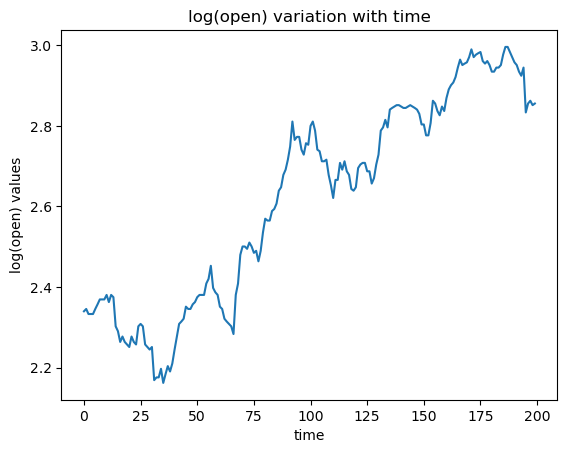

In [99]:
# Plotting the last 200 values
plt.plot(log_open[-200:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('log(open) values')

# Setting the title of the plot
plt.title('log(open) variation with time')
plt.show()

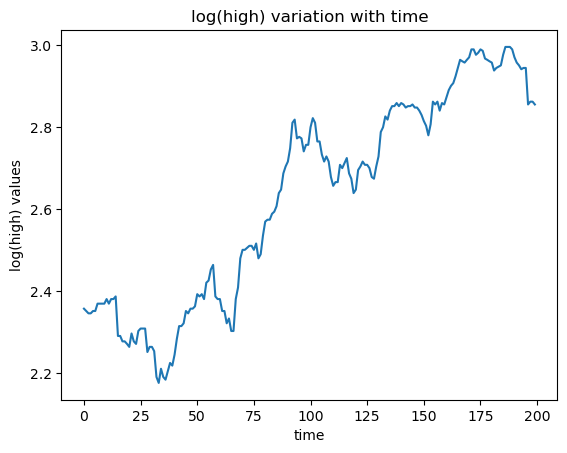

In [100]:
# Plotting the last 200 values
plt.plot(log_high[-200:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('log(high) values')

# Setting the title of the plot
plt.title('log(high) variation with time')

plt.show()

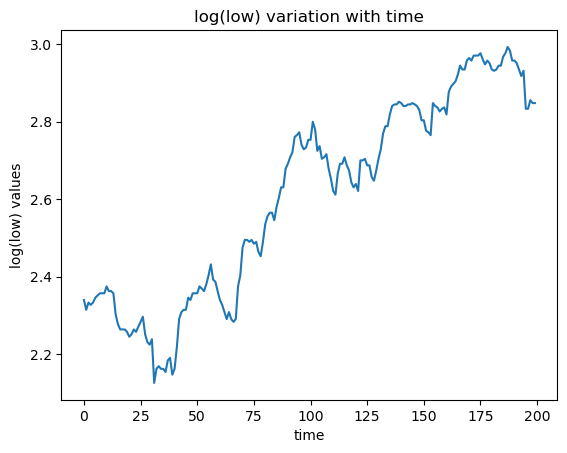

In [101]:
# Plotting the last 200 values
plt.plot(log_low[-200:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('log(low) values')

# Setting the title of the plot
plt.title('log(low) variation with time')

plt.show()

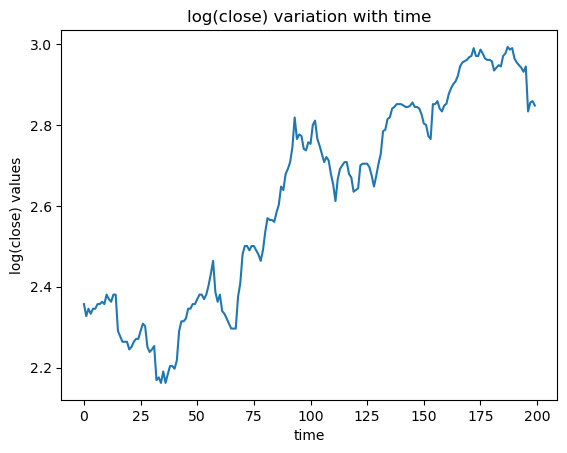

In [102]:
# Plotting the last 200 values
plt.plot(log_close[-200:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('log(close) values')

# Setting the title of the plot
plt.title('log(close) variation with time')

plt.show()

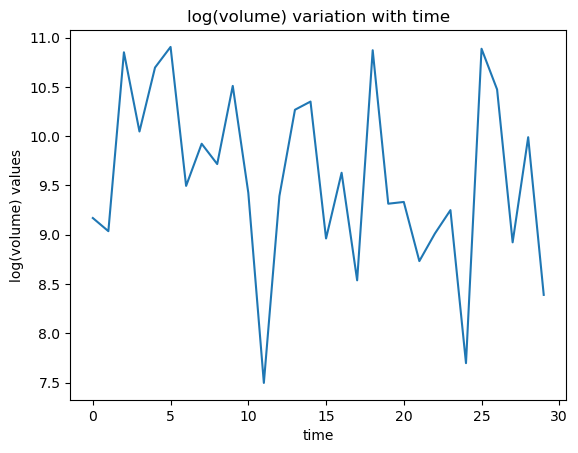

In [103]:
# Plotting the last 30 values
plt.plot(log_volume[-30:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('log(volume) values')

# Setting the title of the plot
plt.title('log(volume) variation with time')

plt.show()

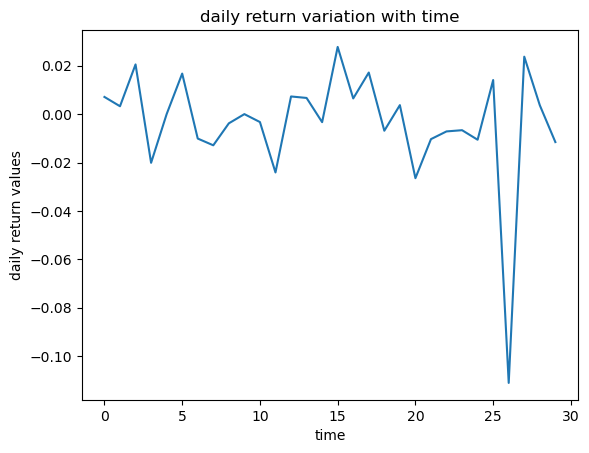

In [104]:
# Plotting the last 30 values
plt.plot(daily_returns[-30:])

# Setting the x-axis label
plt.xlabel('time')

# Setting the y-axis label
plt.ylabel('daily return values')

# Setting the title of the plot
plt.title('daily return variation with time')

plt.show()

This is real world data so these curves are not perfectly smooth. Let's still try to fit a curve to these variables.

Using Cubic Interpolation to predict the next value of these variables

In [105]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [106]:
def get_function(array):
    '''
    This function takes in the sequential array as the input
    It fits the Cubic Spline over that, we are essentially interpolating the curve 
    Then it returns the fitted function and the r2_score
    '''
    f = CubicSpline(np.arange(0, len(array)), array, bc_type='natural')
    y_pred = f(np.arange(0, len(array)))
    return f, r2_score(array, y_pred)
    

In [107]:
get_function(daily_returns)[1]

1.0

In [108]:
print('Interpolated functions with their R2_Score')
print('------------------------------------------')
names = ['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high', 'log_low', 'log_close', 'log_volume', 'daily_return']

i = 0
for array in [open_, high, low, close, volume, log_open, log_high, log_low, log_close, log_volume, daily_returns]:
    print(names[i] + ': ' + str(get_function(array)[1]))
    i+=1



Interpolated functions with their R2_Score
------------------------------------------
open: 1.0
high: 1.0
low: 1.0
close: 1.0
volume: 1.0
log_open: 1.0
log_high: 1.0
log_low: 1.0
log_close: 1.0
log_volume: 1.0
daily_return: 1.0


-------

**Approach**

- We will obtain data for n randomly selected sectors
- We will fit the Cubic Spline and interpolate over the daily_return variable
- Then we will predict the daily_return for the next 100 timestamps and take the mean of that
- We will select n sectors randomly 10 times and do this
- After that, we will plot 10 means of daily returns predicted by our function 
- This will help us understand the variation of daily returns as we diversify our portfolio

In [109]:
# Here are all the sectors
sectors = list(set(sliced_df.sector))
sectors

['',
 'Utilities',
 'Technology',
 'Consumer Cyclical',
 'Basic Materials',
 'REAL ESTATE & CONSTRUCTION',
 'Energy',
 'Consumer Defensive',
 'FINANCE',
 'Financial Services',
 'LIFE SCIENCES',
 'TRADE & SERVICES',
 'Healthcare',
 'Industrials',
 'MANUFACTURING',
 'TECHNOLOGY',
 'Communication Services',
 'Real Estate',
 'ENERGY & TRANSPORTATION']

In [110]:
def predicted_returns(no_of_sectors):
    '''
    This function takes in the number of sectors as 'n'
    It generates 10 randomly selected n sectors 
    Then it gets the rows from the dataframe which belong to those sectors
    Then it obtain the daily returns for those sectors
    
    Using those returns, we fit the Cubic Spline function using the get_function() method
    Using the fitted function, we predict the daily returns for the next 100 timestamps and then we take the mean of that
    
    Since we generated n random sectors 10 times, we get 10 means as our output
    '''
    
    # Creating a list of lists
    # wherein each list is n randomly selected sectors
    s = [random.sample(sectors, no_of_sectors) for i in range(10)]
    
    # Initialisng a list to store the mean of returns
    means = []
    
    for sector in s:
        
        df_temp = sliced_df[sliced_df.sector.isin(sector)]
        
        returns = daily_returns[sliced_df.sector.isin(sector)]
        
        f, score = get_function(returns)
    
        # Predict for the next 100 timestamps
        timestamps = np.arange(len(returns), len(returns)+100)
        y_pred = f(timestamps)
        
        # Appending the mean of the returns
        means.append(y_pred.mean())
    
    return sum(means)/len(means)
    


When we randomly choose sectors 10 times. We can understand the estimated returns we would get for a level of diversification. Earlier we worked on our data, now we are making predictions using the cubic curves we have fit over our data.

In [111]:
j = 10
one_sector = [predicted_returns(1) for i in range(j)]
two_sectors = [predicted_returns(2) for i in range(j)]
three_sectors = [predicted_returns(3) for i in range(j)]
four_sectors = [predicted_returns(4) for i in range(j)]
five_sectors = [predicted_returns(5) for i in range(j)]
six_sectors = [predicted_returns(6) for i in range(j)]
seven_sectors = [predicted_returns(7) for i in range(j)]
eight_sectors = [predicted_returns(8) for i in range(j)]
nine_sectors = [predicted_returns(9) for i in range(j)]
ten_sectors = [predicted_returns(10) for i in range(j)]
eleven_sectors = [predicted_returns(11) for i in range(j)]
twelve_sectors = [predicted_returns(12) for i in range(j)]
thirteen_sectors = [predicted_returns(13) for i in range(j)]
fourteen_sectors = [predicted_returns(14) for i in range(j)]
fifteen_sectors = [predicted_returns(15) for i in range(j)]
sixteen_sectors = [predicted_returns(16) for i in range(j)]
seventeen_sectors = [predicted_returns(17) for i in range(j)]
eighteen_sectors = [predicted_returns(18) for i in range(j)]

In [112]:
temp = pd.DataFrame({'1': one_sector, '2':two_sectors, '3':three_sectors,
                     '4': four_sectors, '5':five_sectors, '6':six_sectors,
                     '7': seven_sectors, '8':eight_sectors, '9':nine_sectors,
                     '10': ten_sectors, '11':eleven_sectors, '12':twelve_sectors,
                     '13': thirteen_sectors, '14': fourteen_sectors, '15': fifteen_sectors,
                     '16': sixteen_sectors, '17': seventeen_sectors, '18': eighteen_sectors
                    })
temp.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1887.482697,-3489.720076,-4159.064550,-4296.079654,-6906.246685,-6685.001204,-5296.592898,-4918.071488,-4396.292022,-4718.064117,-4995.794599,-5285.058990,-5894.001454,-5894.001454,-4963.286895,-5273.525081,-4653.048709,-4653.048709
1,5282.999848,-7133.207878,-5389.572127,-10933.964349,-705.313258,-5916.633615,-5952.769092,-6329.196481,-5005.234486,-4685.556413,-5583.763268,-4674.022505,-4674.022505,-4674.022505,-4984.260691,-4653.048709,-4653.048709,-4653.048709
2,-3208.611643,4886.463910,-4407.335099,-6855.173452,-7636.033646,-3491.384819,-5916.993573,-5926.509158,-5595.297176,-4585.344044,-4095.493723,-4694.996300,-5894.001454,-5294.498877,-5894.001454,-4984.260691,-5273.525081,-4963.286895
3,6248.486446,-6096.392726,-2156.678152,-115.399312,-6611.124468,-3755.497767,-5751.009367,-5561.615677,-5088.243736,-5786.443219,-4984.260691,-5294.498877,-6204.239640,-4963.286895,-5273.525081,-5273.525081,-4653.048709,-4963.286895
4,-2191.661807,-4272.282991,-7832.898785,-7820.931920,-8314.917699,-8536.334522,-5051.370120,-2573.487505,-4984.260691,-5561.615677,-5315.472673,-4986.354712,-5294.498877,-4086.053836,-5273.525081,-5273.525081,-4653.048709,-4653.048709


In [113]:
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1887.482697,-3489.720076,-4159.064550,-4296.079654,-6906.246685,-6685.001204,-5296.592898,-4918.071488,-4396.292022,-4718.064117,-4995.794599,-5285.058990,-5894.001454,-5894.001454,-4963.286895,-5273.525081,-4653.048709,-4653.048709
1,5282.999848,-7133.207878,-5389.572127,-10933.964349,-705.313258,-5916.633615,-5952.769092,-6329.196481,-5005.234486,-4685.556413,-5583.763268,-4674.022505,-4674.022505,-4674.022505,-4984.260691,-4653.048709,-4653.048709,-4653.048709
2,-3208.611643,4886.463910,-4407.335099,-6855.173452,-7636.033646,-3491.384819,-5916.993573,-5926.509158,-5595.297176,-4585.344044,-4095.493723,-4694.996300,-5894.001454,-5294.498877,-5894.001454,-4984.260691,-5273.525081,-4963.286895
3,6248.486446,-6096.392726,-2156.678152,-115.399312,-6611.124468,-3755.497767,-5751.009367,-5561.615677,-5088.243736,-5786.443219,-4984.260691,-5294.498877,-6204.239640,-4963.286895,-5273.525081,-5273.525081,-4653.048709,-4963.286895
4,-2191.661807,-4272.282991,-7832.898785,-7820.931920,-8314.917699,-8536.334522,-5051.370120,-2573.487505,-4984.260691,-5561.615677,-5315.472673,-4986.354712,-5294.498877,-4086.053836,-5273.525081,-5273.525081,-4653.048709,-4653.048709
5,-5374.670967,4850.846847,-6126.370349,-1829.947610,-4719.740772,-5175.936826,-4897.676252,-4918.071488,-7493.873686,-4694.996300,-6215.773548,-5583.763268,-5273.525081,-4363.784318,-6204.239640,-4963.286895,-4963.286895,-4963.286895
6,230.745547,-5281.031904,-3533.682635,-4605.475201,-9538.445263,-6671.637589,-5559.521656,-5648.778675,-5795.883106,-4095.493723,-4995.794599,-5315.472673,-5273.525081,-5273.525081,-5273.525081,-4653.048709,-4653.048709,-4653.048709
7,-4243.437036,-3739.470480,-3785.919963,-4073.346133,-4109.444411,-3706.358632,-5886.579890,-4116.467519,-6338.636368,-4396.292022,-5273.525081,-5294.498877,-4653.048709,-4664.582617,-5583.763268,-4963.286895,-4653.048709,-4653.048709
8,-2645.599403,-4141.679051,-124.661771,-6819.406446,-3552.951256,-4748.477799,-6393.633330,-5239.843583,-5327.006581,-3806.229333,-5005.234486,-5583.763268,-5294.498877,-5583.763268,-5296.592898,-5583.763268,-5273.525081,-4963.286895
9,-5801.995635,-1587.033029,-3715.798519,-6011.402396,-4474.679559,-7503.655241,-3995.623022,-6071.861235,-6170.558142,-4384.758114,-6514.477826,-6514.477826,-5583.763268,-4653.048709,-5894.001454,-4653.048709,-4963.286895,-4653.048709


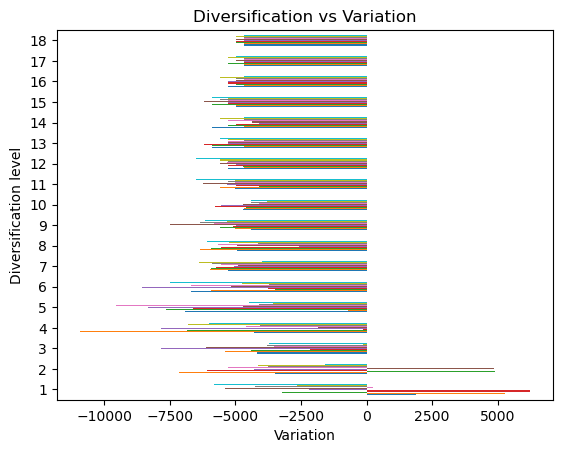

In [114]:
# Plotting the graph
temp.T.plot.barh(legend = False)

# Setting the x-axis label
plt.xlabel('Variation')

# Setting the y-axis label
plt.ylabel('Diversification level')

# Setting the title for the plot
plt.title('Diversification vs Variation')

plt.show()

We can see as we diversify our stocks, the variations in the daily returns reduce significantly. This is not surprising. But we can see that the variations are really high for 7 or less number of stocks. After we have 7 more stocks, the variation reduces significantly. **Therefore, 7 is the point of diminishing returns, after which additional diversification no longer significantly reduces risk.**

### 5.2 Visualisation

In [115]:
df.head()

,id,open,high,low,close,volume,symbol,name,exchange,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
date,,,,,,,,,,,,,,,,,,,,
2023-04-03,2957,9.16,9.27,9.000,9.05,357292.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
2023-03-31,2957,8.90,9.15,8.830,9.09,464772.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2023-03-30,2957,8.65,8.92,8.630,8.83,565275.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
2023-03-29,2957,8.29,8.59,8.252,8.53,379352.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
2023-03-28,2957,8.35,8.39,8.090,8.22,676412.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


In [116]:
# Setting to option to show all the columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [117]:
# Here are the columns
df.columns

Index(['id', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'name',
       'exchange', 'asset_type', 'sector', 'log_open', 'log_high', 'log_low',
       'log_close', 'log_volume', 'daily_return', 'ma_7', 'ma_30',
       'rolling_volatility'],
      dtype='object')

In [119]:
# We have a couple of missing values which are less than 0.001%
df.isnull().sum() / (len(df)) * 100

id                    0.0
open                  0.0
high                  0.0
low                   0.0
close                 0.0
volume                0.0
symbol                0.0
name                  0.0
exchange              0.0
asset_type            0.0
sector                0.0
log_open              0.0
log_high              0.0
log_low               0.0
log_close             0.0
log_volume            0.0
daily_return          0.0
ma_7                  0.0
ma_30                 0.0
rolling_volatility    0.0
dtype: float64

Stock data is highly variable. In this case, imputing mean/median or using some model to impute the missing values would be just wrong since there is too much variation. That would be adding wrong information. That's why, we are dropping these minute number of values.

In [120]:
# Dropping missing values
df = df.dropna()

In [121]:
df.isnull().sum()

id                    0
open                  0
high                  0
low                   0
close                 0
volume                0
symbol                0
name                  0
exchange              0
asset_type            0
sector                0
log_open              0
log_high              0
log_low               0
log_close             0
log_volume            0
daily_return          0
ma_7                  0
ma_30                 0
rolling_volatility    0
dtype: int64

In [122]:
df.head()

,id,open,high,low,close,volume,symbol,name,exchange,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
date,,,,,,,,,,,,,,,,,,,,
2023-04-03,2957,9.16,9.27,9.000,9.05,357292.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
2023-03-31,2957,8.90,9.15,8.830,9.09,464772.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2023-03-30,2957,8.65,8.92,8.630,8.83,565275.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
2023-03-29,2957,8.29,8.59,8.252,8.53,379352.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
2023-03-28,2957,8.35,8.39,8.090,8.22,676412.0,SMR,NuScale Power Corporation - Class A,NYSE,Stock,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


In [123]:
sliced_df = df.drop(['id', 'symbol', 'name', 'exchange'], axis=1).copy()

In [124]:
sliced_df.head()

,open,high,low,close,volume,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
date,,,,,,,,,,,,,,,,
2023-04-03,9.16,9.27,9.000,9.05,357292.0,Stock,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
2023-03-31,8.90,9.15,8.830,9.09,464772.0,Stock,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2023-03-30,8.65,8.92,8.630,8.83,565275.0,Stock,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
2023-03-29,8.29,8.59,8.252,8.53,379352.0,Stock,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
2023-03-28,8.35,8.39,8.090,8.22,676412.0,Stock,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


In [125]:
# Resetting the index
sliced_df.reset_index(inplace = True)

# Dropping the date column
sliced_df.drop(['date'], axis = 1, inplace = True)

sliced_df.head()

,open,high,low,close,volume,asset_type,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
0,9.16,9.27,9.000,9.05,357292.0,Stock,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
1,8.90,9.15,8.830,9.09,464772.0,Stock,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2,8.65,8.92,8.630,8.83,565275.0,Stock,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
3,8.29,8.59,8.252,8.53,379352.0,Stock,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
4,8.35,8.39,8.090,8.22,676412.0,Stock,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


Our objective is to understand at what point does diversification stops being helpful. Diversification is defined by the number of sectors that we invest it. At a certain diversification level, the mean of the daily returns tells us the average earnings while the standard deviation tells us the risk. Plotting both of these together can be really insightful.
We already talked about the optimal level of diversification levels while we created portfolios using random sectors and analysed the mean and standard deviations to understand the daily returns and associated risks. Another important question is to understand which stock to choose when we want to diversify. It depends on the earning goals and the risks we are willing to take. 

Let's understand the distribution of sectors we have in our dataset

In [126]:
sliced_df.sector.value_counts(normalize = True).sort_values(ascending = False) * 100

sector
Industrials                   14.475321
Financial Services            14.221892
Consumer Cyclical             10.757689
Real Estate                    9.031048
Energy                         7.575029
Basic Materials                6.750911
Technology                     5.869619
Healthcare                     5.161893
Consumer Defensive             4.677574
Utilities                      3.736709
Communication Services         3.052038
ENERGY & TRANSPORTATION        2.592198
REAL ESTATE & CONSTRUCTION     2.567825
TECHNOLOGY                     2.449066
FINANCE                        2.302686
MANUFACTURING                  1.810340
TRADE & SERVICES               1.693712
LIFE SCIENCES                  0.658791
                               0.615659
Name: proportion, dtype: float64

**Here are the top stocks that represent the market:-**

| Stocks             | Percentage |
| ------------------ | ---------- |
| Industrials        |   14.57%   |
| Financial Services |   14.31%   |
| Consumer Services  |   10.83%   |
| Real Estate        |    9.09%   |
| Energy             |    7.62%   |
| Basic Materials    |    6.79%   |

In [127]:
# This column is useless
sliced_df['asset_type'].value_counts(normalize = True)

asset_type
Stock    1.0
Name: proportion, dtype: float64

In [128]:
# Dropping this column
sliced_df.drop(['asset_type'], axis = 1, inplace = True)

In [129]:
import matplotlib.pyplot as plt

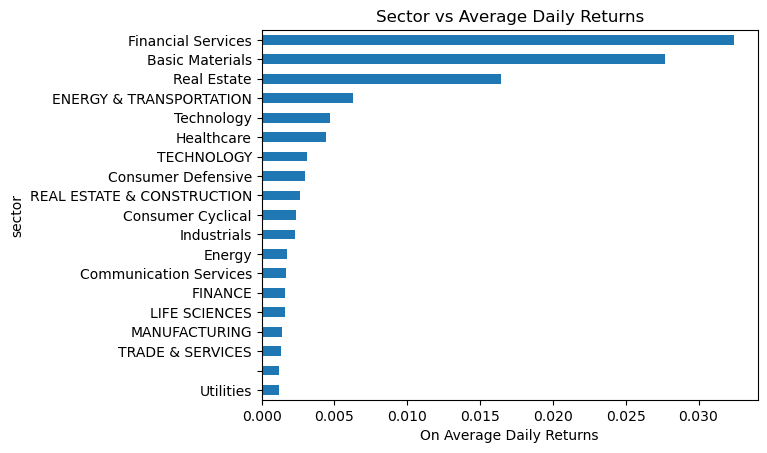

In [130]:
sliced_df.groupby(by = 'sector')['daily_return'].mean().sort_values().plot.barh()
plt.xlabel('On Average Daily Returns')
plt.title('Sector vs Average Daily Returns')
plt.show()

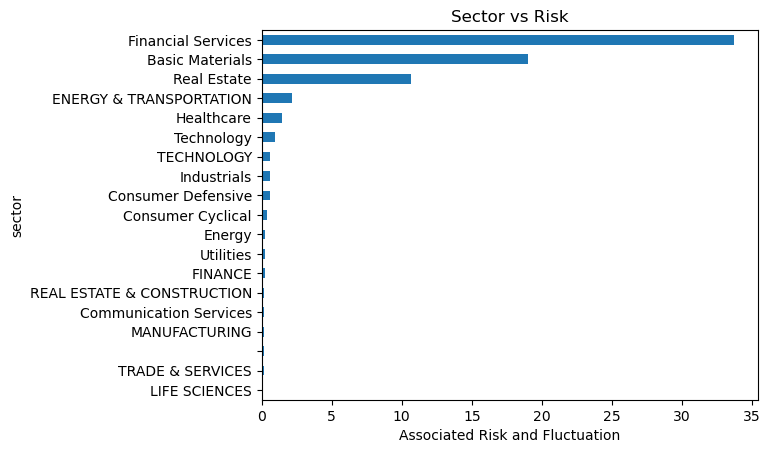

In [131]:
sliced_df.groupby(by = 'sector')['daily_return'].std().sort_values().plot.barh()
plt.xlabel('Associated Risk and Fluctuation')
plt.title('Sector vs Risk')
plt.show()

In [132]:
df_major_sectors = sliced_df[sliced_df.sector.isin(['Financial Services', 'Basic Materials', 'Real Estate'])].copy()
df_major_sectors.head()

,open,high,low,close,volume,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
22112,0.95,0.95,0.85,0.85,13600.0,Financial Services,0.667829,0.667829,0.615186,0.615186,9.517899,-0.827935,4.408571,5.140333,0.153066
22113,0.95,0.95,0.90,0.90,5000.0,Financial Services,0.667829,0.667829,0.641854,0.641854,8.517393,0.058824,3.795714,4.980667,0.153637
22114,0.95,1.01,0.85,0.93,7900.0,Financial Services,0.667829,0.698135,0.615186,0.657520,8.974745,0.033333,3.205714,4.824333,0.154043
22115,0.87,0.95,0.80,0.95,40800.0,Financial Services,0.625938,0.667829,0.587787,0.667829,10.616462,0.021505,2.627143,4.676667,0.154284
22116,0.87,0.87,0.87,0.87,0.0,Financial Services,0.625938,0.625938,0.625938,0.625938,0.000000,-0.084211,2.045714,4.528667,0.154620


In [133]:
df_other_factors = sliced_df[~sliced_df.sector.isin(['Financial Services', 'Basic Materials', 'Real Estate'])].copy()
df_other_factors.head()

,open,high,low,close,volume,sector,log_open,log_high,log_low,log_close,log_volume,daily_return,ma_7,ma_30,rolling_volatility
0,9.16,9.27,9.000,9.05,357292.0,Industrials,2.318458,2.329227,2.302585,2.307573,12.786311,0.047454,8.635714,8.494667,0.025626
1,8.90,9.15,8.830,9.09,464772.0,Industrials,2.292535,2.317474,2.285439,2.311545,13.049304,0.004420,8.678571,8.521000,0.024372
2,8.65,8.92,8.630,8.83,565275.0,Industrials,2.266958,2.294553,2.264883,2.285439,13.245069,-0.028603,8.687143,8.538667,0.025057
3,8.29,8.59,8.252,8.53,379352.0,Industrials,2.228939,2.260721,2.224840,2.254445,12.846222,-0.033975,8.700000,8.546333,0.025920
4,8.35,8.39,8.090,8.22,676412.0,Industrials,2.235376,2.239645,2.207175,2.221375,13.424559,-0.036342,8.692857,8.555667,0.025532


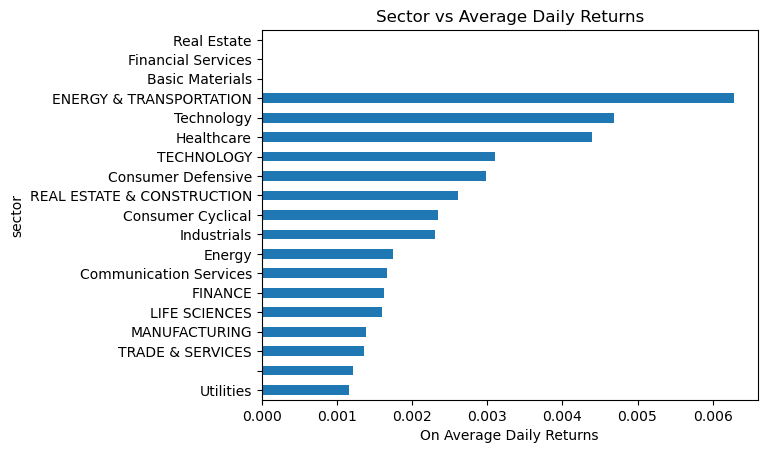

In [134]:
df_other_factors.groupby(by = 'sector')['daily_return'].mean().sort_values().plot.barh()
plt.xlabel('On Average Daily Returns')
plt.title('Sector vs Average Daily Returns')
plt.show()

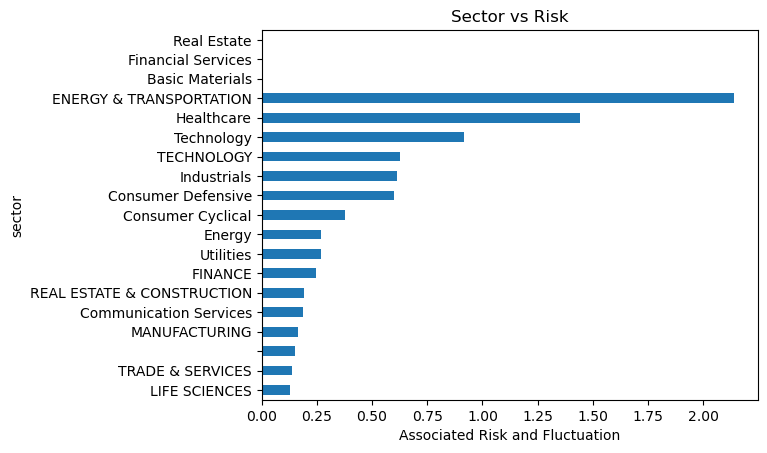

In [135]:
df_other_factors.groupby(by = 'sector')['daily_return'].std().sort_values().plot.barh()
plt.xlabel('Associated Risk and Fluctuation')
plt.title('Sector vs Risk')
plt.show()

Let's create a new feature to measure the daily_return vs risk factor. That would tell us the relative risk and reward ratio of these sectors

In [136]:
sliced_df.groupby(by = 'sector')['daily_return'].mean()

sector
                              0.001209
Basic Materials               0.027707
Communication Services        0.001662
Consumer Cyclical             0.002352
Consumer Defensive            0.002979
ENERGY & TRANSPORTATION       0.006284
Energy                        0.001746
FINANCE                       0.001627
Financial Services            0.032436
Healthcare                    0.004395
Industrials                   0.002312
LIFE SCIENCES                 0.001596
MANUFACTURING                 0.001392
REAL ESTATE & CONSTRUCTION    0.002613
Real Estate                   0.016463
TECHNOLOGY                    0.003101
TRADE & SERVICES              0.001358
Technology                    0.004689
Utilities                     0.001164
Name: daily_return, dtype: float64

In [137]:
sliced_df.groupby(by = 'sector')['daily_return'].std()

sector
                               0.150913
Basic Materials               18.990199
Communication Services         0.186499
Consumer Cyclical              0.375808
Consumer Defensive             0.598131
ENERGY & TRANSPORTATION        2.139189
Energy                         0.268995
FINANCE                        0.244189
Financial Services            33.709833
Healthcare                     1.441458
Industrials                    0.611931
LIFE SCIENCES                  0.128825
MANUFACTURING                  0.166374
REAL ESTATE & CONSTRUCTION     0.190858
Real Estate                   10.673959
TECHNOLOGY                     0.626656
TRADE & SERVICES               0.136120
Technology                     0.918345
Utilities                      0.268851
Name: daily_return, dtype: float64

In [138]:
reward_vs_risk = sliced_df.groupby(by = 'sector')['daily_return'].mean() / sliced_df.groupby(by = 'sector')['daily_return'].std()
reward_vs_risk

sector
                              0.008011
Basic Materials               0.001459
Communication Services        0.008909
Consumer Cyclical             0.006257
Consumer Defensive            0.004980
ENERGY & TRANSPORTATION       0.002938
Energy                        0.006489
FINANCE                       0.006663
Financial Services            0.000962
Healthcare                    0.003049
Industrials                   0.003778
LIFE SCIENCES                 0.012388
MANUFACTURING                 0.008364
REAL ESTATE & CONSTRUCTION    0.013689
Real Estate                   0.001542
TECHNOLOGY                    0.004949
TRADE & SERVICES              0.009976
Technology                    0.005106
Utilities                     0.004328
Name: daily_return, dtype: float64

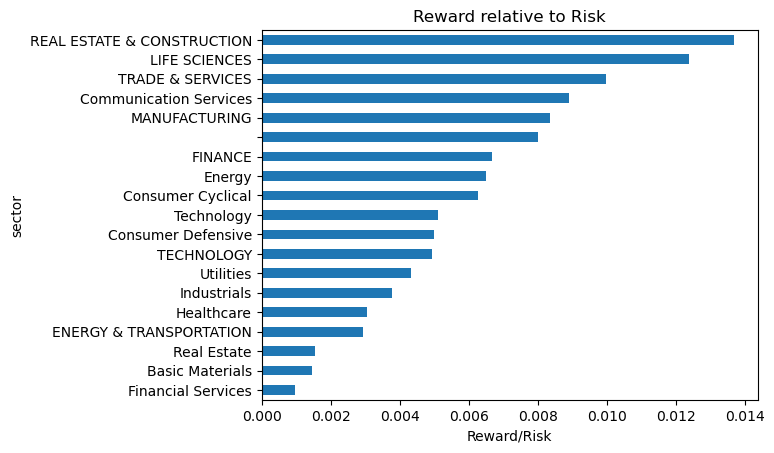

In [139]:
reward_vs_risk.sort_values().plot.barh()
plt.xlabel('Reward/Risk')
plt.title('Reward relative to Risk')
plt.show()

This tells us that Trade & Services, Real Estate & Construction, Communication services, Manufacturing, Finance and Life Science are some of the most rewarding sectors. Whereas, Financial Services, Basic Materials and Real Estate are some of the worst.

So, in order to obtain a high stable income, these are the sectors one should diversify their investments into if they want the maximum reward with minimum risk.

## 6. Interpretation, Conclusion and Reporting

We saw that after number of sectors increase to 7, the optimal level of diversification has been achieved after which we don't get that much improvement on the reward. We did this by choosing random number of sectors 10 times and calculating the mean of their daily returns. We did this to our data after the Database Cleaning (3.3) part when we build our portfolios. 

If someone is randomly diversifying their portfolio, they need to diversify with a lot of stocks. Their investment becomes safer but they don't get significant returns. It is also difficult to keep track of so many stocks and analysing which one is performing well and which ones are bad. 
On the other hand, diversification is necessary. We can't put all of our bags in one basket. But it should be done thoughtfully. Ideally, 5-6 stocks should be enough since the investor also needs to keep track of these stocks. Investing in more stocks would eventually become unmanageable. 

We analysed this in the Optimisation and Visualisation part where we fit our daily returns with n randomly selected sectors, we did this 10 times for each sector. We saw in the plot that after the number of stocks have increased to 7, we no longer see significant improvements in our daily returns. 

When someone is looking to diversify their portfolio, they have their own set of priorities. So depending on their priorities, different stocks would fit to their requirements and goals.  
Here's a table that is valuable information for anyone looking to choose stocks when diversifying their portfolio

| Highest Returns    | Lowest Risks     | Highest Returns with Lowest Risks |
| ------------------ | ---------------- | --------------------------------- |
| Financial Services | Trade & Services | Trade & Services                  |
| Basic Materials    | Life Sciences    | Real Estate & Construction        |
| Real Estate        | Manufacturing    | Life Sciences                     |

The stock market is influenced by a range of factors. When we tried to fit a Linear Regression model, we saw it couldn't predict the daily_returns accurately. This is not surprising at all. We would definitely need more data and bigger models to train in order to achieve a satisfactory accuracy. On the other hand, we can still analyse a particular range of sectors as a whole and make decisive and informed actions. 

-------